100
[-8.16e-01 -9.49e-01 -9.85e-01 -6.59e-01 -9.36e-01 -1.02e+00 -7.44e-01
 -9.96e-01 -9.99e-01 -7.50e-01 -1.00e+00 -9.07e-01 -1.07e+00 -1.23e+00
 -6.52e-01 -9.06e-01 -9.13e-01 -2.43e-01  1.35e+01  1.56e+02 -7.13e-01
  6.17e+01  2.79e+01  1.16e+00  1.12e+01 -9.03e-02 -7.64e-02 -5.30e-01
  3.27e+00  2.08e+01  1.61e+01  1.96e+00  4.78e+00 -8.86e-01 -8.53e-01
 -1.30e-01 -5.86e-01  6.51e+01  2.47e+01  5.85e+00  2.17e+00  1.80e+02
  1.33e-01  4.07e-01  2.85e+01  2.32e-01 -9.17e-01 -8.55e-01  5.09e+00
  1.48e+02  1.01e+01  1.03e+02 -4.40e-01  5.62e-04 -2.82e-01  1.19e+00
 -4.79e-01  1.19e+00  2.96e+00 -8.46e-02  1.10e-01 -9.92e-01  6.10e-01
 -1.24e+00  7.59e-01  1.26e+01  2.23e+01  3.33e+01  1.07e+00  2.14e+00
  2.86e+02  1.25e+01  2.12e+02  3.60e+00  6.27e+00  1.46e+02  7.20e+01
  7.72e+01  5.02e+01 -2.50e-01  2.17e+01 -5.08e-01 -3.79e-01  1.55e+00
  2.61e+00  3.25e+02  8.71e+01  3.96e+00  3.57e-01 -6.73e-01 -6.40e-01
  5.53e+00  5.81e+01  1.99e+02  1.75e+01  2.79e+01  3.47e+00  1.03e+02
  

c:\Anaconda3\envs\pytorch_gpu\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


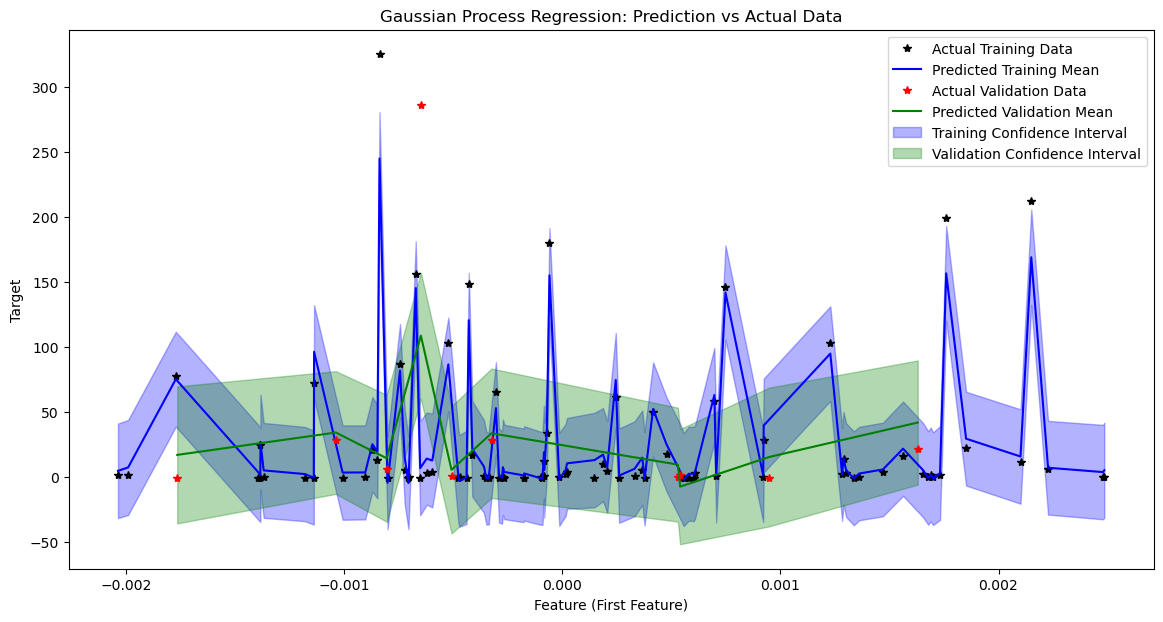

Validation RMSE: 57.26245880126953
Validation R²: 0.5329878470842777


In [2]:
import torch
import gpytorch
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the features and labels
features = np.load('round0_Zvectors_sorted.npy')  # Update the path accordingly
labels_df = pd.read_csv('Rint_round0_0807.csv')  # Update the path accordingly
labels = labels_df.iloc[:, 0].values
print(labels.shape[0])
print(labels)
# features = features[:labels.shape[0], :]

# # Standardize the features and labels
# scaler_features = StandardScaler()
# features_scaled = scaler_features.fit_transform(features)

# scaler_labels = StandardScaler()
# labels_scaled = scaler_labels.fit_transform(labels.reshape(-1, 1)).flatten()

# # Apply PowerTransformer to features and labels
# scaler_features = PowerTransformer()
# features_scaled = scaler_features.fit_transform(features)

# scaler_labels = PowerTransformer()
# labels_scaled = scaler_labels.fit_transform(labels.reshape(-1, 1)).flatten()

features_scaled = features
labels_scaled = labels.reshape(-1, 1).flatten()


# Split data into training and validation sets
train_x, test_x, train_y, test_y = train_test_split(features_scaled, labels_scaled, test_size=0.1, random_state=42)

# Convert to tensors
train_x_tensor = torch.tensor(train_x, dtype=torch.float32).cuda()
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).cuda()
test_x_tensor = torch.tensor(test_x, dtype=torch.float32).cuda()
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).cuda()
# test_x_tensor = torch.tensor(train_x, dtype=torch.float32).cuda()
# test_y_tensor = torch.tensor(train_y, dtype=torch.float32).cuda()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel() + gpytorch.kernels.MaternKernel(nu=1.5) #################
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-4)).cuda() #################
model = GPRegressionModel(train_x_tensor, train_y_tensor, likelihood).cuda()

# Set the model and likelihood to training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 40000
early_stopping_patience = 1000
best_loss = float('inf')
early_stopping_counter = 0

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_tensor)
    loss = -mll(output, train_y_tensor)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 500 == 0:
        print(f'Iteration {i+1}/{training_iterations} - Loss: {loss.item():.4f}')
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > early_stopping_patience:
        print(f"Early stopping at iteration {i+1}")
        break

# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Make predictions on training data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_predictions = likelihood(model(train_x_tensor))
    train_mean = train_predictions.mean
    train_lower, train_upper = train_predictions.confidence_region()

# Make predictions on validation data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_predictions = likelihood(model(test_x_tensor))
    test_mean = test_predictions.mean
    test_lower, test_upper = test_predictions.confidence_region()

# Save the model and likelihood
model_save_path = "saved_model/gpr_model.pth"  # Update the path accordingly
torch.save({
    'model_state_dict': model.state_dict(),
    'likelihood_state_dict': likelihood.state_dict()
}, model_save_path)
print(f"Model saved to {model_save_path}")

# Select the first feature for plotting
train_x_plot = train_x_tensor[:, 0]
test_x_plot = test_x_tensor[:, 0]

# Sort the training data and predictions by the first feature for a cleaner plot
sorted_train_indices = torch.argsort(train_x_plot)
sorted_train_x_tensor = train_x_plot[sorted_train_indices]
sorted_train_y_tensor = train_y_tensor[sorted_train_indices]
sorted_train_mean = train_mean[sorted_train_indices]
sorted_train_lower = train_lower[sorted_train_indices]
sorted_train_upper = train_upper[sorted_train_indices]

# Sort the validation data and predictions similarly
sorted_test_indices = torch.argsort(test_x_plot)
sorted_test_x_tensor = test_x_plot[sorted_test_indices]
sorted_test_y_tensor = test_y_tensor[sorted_test_indices]
sorted_test_mean = test_mean[sorted_test_indices]
sorted_test_lower = test_lower[sorted_test_indices]
sorted_test_upper = test_upper[sorted_test_indices]

# Plot results
plt.figure(figsize=(14, 7))

# Training data
plt.plot(sorted_train_x_tensor.cpu().numpy(), sorted_train_y_tensor.cpu().numpy(), 'k*', label='Actual Training Data')
plt.plot(sorted_train_x_tensor.cpu().numpy(), sorted_train_mean.cpu().numpy(), 'b', label='Predicted Training Mean')
plt.fill_between(sorted_train_x_tensor.cpu().numpy(), 
                 sorted_train_lower.cpu().numpy(), 
                 sorted_train_upper.cpu().numpy(), 
                 color='blue', alpha=0.3, label='Training Confidence Interval')

# Validation data
plt.plot(sorted_test_x_tensor.cpu().numpy(), sorted_test_y_tensor.cpu().numpy(), 'r*', label='Actual Validation Data')
plt.plot(sorted_test_x_tensor.cpu().numpy(), sorted_test_mean.cpu().numpy(), 'g', label='Predicted Validation Mean')
plt.fill_between(sorted_test_x_tensor.cpu().numpy(), 
                 sorted_test_lower.cpu().numpy(), 
                 sorted_test_upper.cpu().numpy(), 
                 color='green', alpha=0.3, label='Validation Confidence Interval')

plt.legend()
plt.title("Gaussian Process Regression: Prediction vs Actual Data")
plt.xlabel("Feature (First Feature)")
plt.ylabel("Target")
plt.show()

# Calculate RMSE and R^2 for validation set
rmse = mean_squared_error(test_y_tensor.cpu(), test_mean.cpu(), squared=False)
r2 = r2_score(test_y_tensor.cpu(), test_mean.cpu())

print(f'Validation RMSE: {rmse}')
print(f'Validation R²: {r2}')